In [19]:
!pip install tensorflow==2.13.0 --force-reinstall
!pip install tflite-support
!wget https://storage.googleapis.com/sweple.appspot.com/models/model.h5
!wget https://storage.googleapis.com/sweple.appspot.com/dataset229.zip
!wget https://storage.googleapis.com/sweple.appspot.com/models/saved%20\(1\).tflite -O /content/model.tflite

--2024-06-16 16:16:28--  https://storage.googleapis.com/sweple.appspot.com/models/model.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.157.207, 142.251.8.207, 142.251.170.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.157.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91755048 (88M) [application/x-hdf5]
Saving to: ‘model.h5’

model.h5            100%[===================>]  87.50M  26.2MB/s    in 3.3s    

2024-06-16 16:16:32 (26.2 MB/s) - ‘model.h5’ saved [91755048/91755048]



In [1]:
from tflite_support import metadata_schema_py_generated as _metadata_fb
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tflite_support.metadata_writers import writer_utils
from sklearn.model_selection import train_test_split
from tflite_support import metadata as _metadata
from tflite_support import metadata_writers
from tflite_support import metadata
from google.colab.files import upload
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import numpy as np
import flatbuffers
import zipfile
import shutil
import os
import io


## Extract And Split Dataset

In [2]:
current_dir = os.getcwd()
local_zip = './dataset229.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [3]:
# Split dataset into training and testing sets

dataset_dir = "dataset"
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')


os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


for i in os.listdir(dataset_dir):
    sub_dir = os.listdir(os.path.join(dataset_dir, i))
    for j in sub_dir:
        cat_dir = os.path.join(os.path.join(dataset_dir, i), j)

        if os.path.isdir(cat_dir):
            os.makedirs(os.path.join(train_dir, j), exist_ok=True)
            os.makedirs(os.path.join(test_dir, j), exist_ok=True)

            images = os.listdir(cat_dir)

            train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

            for image in train_images:
                shutil.move(os.path.join(cat_dir, image), os.path.join(train_dir, j, image))
            for image in test_images:
                shutil.move(os.path.join(cat_dir, image), os.path.join(test_dir, j, image))

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(229, 229),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(229, 229),
    batch_size=32,
    class_mode='categorical'
)

Found 43219 images belonging to 283 classes.
Found 13374 images belonging to 283 classes.


In [5]:
classes_train = train_generator.class_indices
classes_test = test_generator.class_indices
print("Training samples:", train_generator.samples)
print("Testing samples:", test_generator.samples)

Training samples: 43219
Testing samples: 13374


## Load and test model h5

In [20]:
model = tf.keras.models.load_model('/content/model.h5')

TypeError: Error when deserializing class 'InputLayer' using config={'batch_shape': [None, 229, 229, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}.

Exception encountered: Unrecognized keyword arguments: ['batch_shape']

Saving b05bdf4f-0b3d-424e-9253-4185e325818f.jpg to b05bdf4f-0b3d-424e-9253-4185e325818f.jpg
Saving e54d87132c708456efb1e4032c5e9a62.jpg to e54d87132c708456efb1e4032c5e9a62 (1).jpg
User uploaded file "b05bdf4f-0b3d-424e-9253-4185e325818f.jpg" with length 86021 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


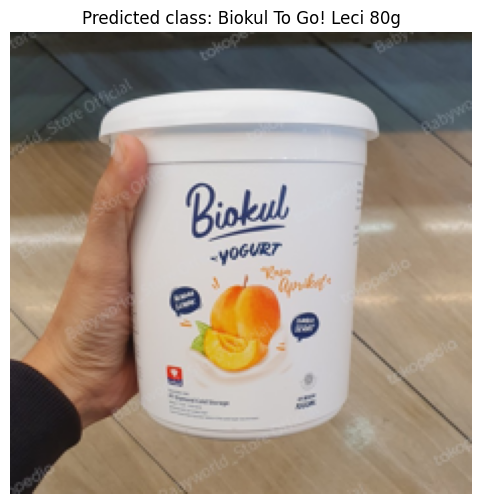

User uploaded file "e54d87132c708456efb1e4032c5e9a62 (1).jpg" with length 216342 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


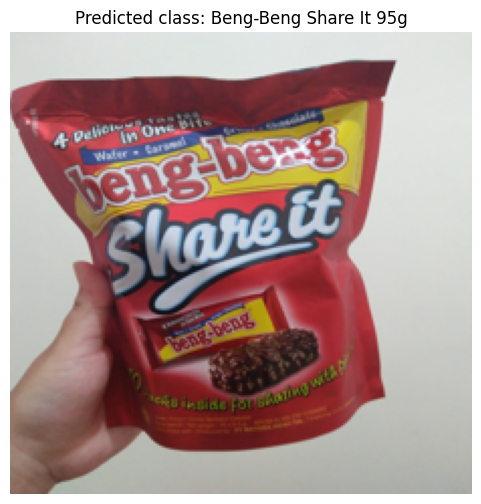

In [ ]:
uploaded = upload()

for filename in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=filename, length=len(uploaded[filename])))

    # Load the uploaded image
    image = Image.open(io.BytesIO(uploaded[filename]))

    # Preprocess the image
    image = image.resize((229, 229))
    image_array = np.array(image) / 255.0
    image_tensor = np.expand_dims(image_array, axis=0)

    # Make predictions
    predictions = model.predict(image_tensor)
    predicted_class = np.argmax(predictions[0])

    # Display the image with the predicted label
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Predicted class: {list(classes_train.keys())[list(classes_train.values()).index(predicted_class)]}")
    plt.axis('off')
    plt.show()

## Generate labels for metadata tflite


In [10]:
sorted_class_indices = sorted(train_generator.class_indices.items(), key=lambda x: x[1])
sorted_class_names = [class_name for class_name, index in sorted_class_indices]

labels_path = "/content/labels.txt"

with open(labels_path, 'w') as f:
    for class_name in sorted_class_names:
        f.write(class_name + '\n')

print(f"Labels saved to {labels_path}")

Labels saved to /content/labels.txt


## Add metadata to tflite

In [15]:
# Paths for the model and label file
_MODEL_PATH = "/content/model.tflite"
_LABEL_FILE = "/content/labels.txt"
_SAVE_TO_PATH = "/content/model_with_metadata.tflite"

# Normalization parameters for the input image
_INPUT_NORM_MEAN = 127.5
_INPUT_NORM_STD = 127.5

# Create model metadata
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "Gizilo image classifier"
model_meta.description = (
    "Identify branded retail products and make grading for these products "
    "based on the calculation of nutritional value."
)
model_meta.version = "v1"
model_meta.author = "Core Gizilo"
model_meta.license = (
    "Apache License. Version 2.0 "
    "http://www.apache.org/licenses/LICENSE-2.0."
)

# Create input metadata
input_meta = _metadata_fb.TensorMetadataT()
input_meta.name = "image"
input_meta.description = (
    "Input image to be classified. The expected image is 229 x 229, with "
    "three channels (red, blue, and green) per pixel. Each value in the "
    "tensor is a single byte between 0 and 255."
)
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
input_meta.content.contentProperties.colorSpace = _metadata_fb.ColorSpaceType.RGB
input_meta.content.contentPropertiesType = _metadata_fb.ContentProperties.ImageProperties

input_normalization = _metadata_fb.ProcessUnitT()
input_normalization.optionsType = _metadata_fb.ProcessUnitOptions.NormalizationOptions
input_normalization.options = _metadata_fb.NormalizationOptionsT()
input_normalization.options.mean = [_INPUT_NORM_MEAN]
input_normalization.options.std = [_INPUT_NORM_STD]
input_meta.processUnits = [input_normalization]

input_stats = _metadata_fb.StatsT()
input_stats.max = [255]
input_stats.min = [0]
input_meta.stats = input_stats

# Create output metadata
output_meta = _metadata_fb.TensorMetadataT()
output_meta.name = "probability"
output_meta.description = "Probabilities of the labels respectively."
output_meta.content = _metadata_fb.ContentT()
output_meta.content.contentProperties = _metadata_fb.FeaturePropertiesT()
output_meta.content.contentPropertiesType = _metadata_fb.ContentProperties.FeatureProperties

output_stats = _metadata_fb.StatsT()
output_stats.max = [1.0]
output_stats.min = [0.0]
output_meta.stats = output_stats

label_file = _metadata_fb.AssociatedFileT()
label_file.name = os.path.basename(_LABEL_FILE)
label_file.description = "Labels for objects that the model can recognize."
label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
output_meta.associatedFiles = [label_file]

# Create subgraph metadata
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]
model_meta.subgraphMetadata = [subgraph]

# Build the flatbuffer
b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER
)
metadata_buf = b.Output()

# Populate metadata into the model
populator = _metadata.MetadataPopulator.with_model_file(_MODEL_PATH)
populator.load_metadata_buffer(metadata_buf)
populator.load_associated_files([_LABEL_FILE])
populator.populate()

# Save the model with metadata
writer_utils.save_file(writer_utils.load_file(_MODEL_PATH), _SAVE_TO_PATH)

# Optionally display metadata
displayer = _metadata.MetadataDisplayer.with_model_file(_SAVE_TO_PATH)
export_json_file = "model_metadata.json"
json_file = displayer.get_metadata_json()

with open(export_json_file, "w") as f:
    f.write(json_file)

print(f"Metadata populated and saved to {_SAVE_TO_PATH}")
print(f"Metadata JSON saved to {export_json_file}")


Metadata populated and saved to /content/model_with_metadata.tflite
Metadata JSON saved to model_metadata.json


In [16]:
displayer = metadata.MetadataDisplayer.with_model_file("/content/model_with_metadata.tflite")
print("Metadata populated:")
print(displayer.get_metadata_json())

print("Associated file(s) populated:")
for file_name in displayer.get_packed_associated_file_list():
  print("file name: ", file_name)
  print("file content:")
  print(displayer.get_associated_file_buffer(file_name))
with open("model_metadata.json", "w") as f:
  f.write(displayer.get_metadata_json())

Metadata populated:
{
  "name": "Gizilo image classifier",
  "description": "Identify branded retail products and make grading for these products based on the calculation of nutritional value.",
  "version": "v1",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be classified. The expected image is 229 x 229, with three channels (red, blue, and green) per pixel. Each value in the tensor is a single byte between 0 and 255.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          

## Test model tflite

In [17]:
# Get user input for the image path
image_path = input("Enter the path to the image you want to predict: ")

# Load the image
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(229, 229))

# Preprocess the image
image = tf.keras.preprocessing.image.img_to_array(image)
image = np.expand_dims(image, axis=0)
image /= 255.0

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/content/model_with_metadata.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Run the model
interpreter.set_tensor(input_details[0]['index'], image)
interpreter.invoke()

# Get the prediction
predictions = interpreter.get_tensor(output_details[0]['index'])

# Print the prediction
predicted_class = np.argmax(predictions)
print(f"Predicted class: {list(classes_train.keys())[list(classes_train.values()).index(predicted_class)]}")

Enter the path to the image you want to predict: /content/e54d87132c708456efb1e4032c5e9a62.jpg
Predicted class: Beng-Beng Share It 95g
